In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from GLM_helpers import *
from swdb_2018_neuropixels.ephys_nwb_adapter import NWB_adapter    

In [3]:
drive_path = '/data/dynamic-brain-workshop/visual_coding_neuropixels'

In [4]:
manifest_file = os.path.join(drive_path,'ephys_manifest.csv')
expt_info_df = pd.read_csv(manifest_file)
multi_probe_expt_info = expt_info_df[expt_info_df.experiment_type == 'multi_probe']
multi_probe_example = 1 # index to row in multi_probe_expt_info
multi_probe_filename  = multi_probe_expt_info.iloc[multi_probe_example]['nwb_filename']
nwb_file = os.path.join(drive_path,multi_probe_filename)
data_set = NWB_adapter(nwb_file)


In [34]:
(binned_spikes, cell_table) = bin_spikes(data_set,0.1,0.4,1.4,regions=['VISp'])


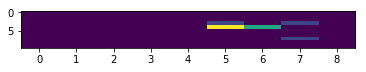

In [35]:
plt.subplots(1,1,figsize=(6,6))
plt.imshow(binned_spikes[15:25,:],aspect=0.1)

In [30]:
# Inputs:
# data_set: EphysObservatory data_set structure
# bin_len: duration of a bin in seconds
# t_start: time to start counting spikes
# t_final: time to stop counting spikes
# probes: list of strings of probe names to be used (default is all probes)
# regions: list of strings of brain regions to be used (default is all regions)
def bin_spikes(data_set,bin_len,t_start,t_final,probes=None,regions=None):
    if probes is None:
        probes = data_set.probe_list
    if regions is None:
        regions = data_set.unit_df.structure.unique()
    
    #gather cells from desired regions and probes into cell_table
    use_cells = False
    for probe in probes:
        for region in regions:
            use_cells |= (data_set.unit_df.probe==probe) & (data_set.unit_df.structure==region)
    cell_table = data_set.unit_df[use_cells]
    
    N = len(cell_table)     #number of cells
    T = int(np.floor((t_final-t_start)/bin_len)) #number of time bins
    binned_spikes = np.zeros((N,T)) # binned_spikes[i,j] is the number of spikes from neuron i in time bin j

    #for each cell in the table, add each spike to the appropriate bin
    i = 0
    for z,cell in cell_table.iterrows(): 
        for spike_time in data_set.spike_times[cell['probe']][cell['unit_id']]:
            t = int(np.floor((spike_time-t_start)/bin_len))
            if (t >=0) & (t<T):
                binned_spikes[i,t] += 1
        i+=1    
    return (binned_spikes, cell_table)

# Inputs
# flat_stimulus: M x T matrix of stimuli
# binned_spikes: N x T matrix of spike counts
# i: index of the neuron we're constructing the matrix for
# d_stim: duration of stimulus filter (# time bins)
# d_spk: duration of spike filters (# time bins)
def construct_GLM_mat(flat_stimulus, binned_spikes, i, d_stim, d_spk):
    (N,T) = binned_spikes.shape # N is number of neurons, T is number of time bins
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
    X_dsn = np.empty((T-d_stim+1,M*d_stim+N*d_spk))
    d_max = max(d_stim,d_spk)
    y = np.empty((T-d_max+1,))
    for t in range(T-d_max+1):
        y[t] = binned_spikes[i,t+d_max-1]
        X_dsn[t,:M*d_stim] = flat_stimulus[:,t+d_max-d_stim:t+d_max].reshape((1,-1))
        X_dsn[t,M*d_stim:] = binned_spikes[:,t+d_max-d_spk:t+d_max].reshape((1,-1))
    return (y, X_dsn)   

[ 0.  0.  0.  0.  0.  5.  3.  0.  0.] [ 0.  0.  5.  3.  0.  0.]


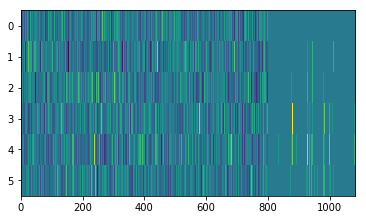

In [39]:
fake_im = np.random.normal(size = (200,binned_spikes.shape[1]))
(y, X_dsn) = construct_GLM_mat(fake_im, binned_spikes, 19, 4, 4)
print binned_spikes[19,:], y
plt.imshow(X_dsn,aspect=100)